In [ ]:
import time
notebook_start_time = time.time()

In [ ]:
# from google.colab import files
# uploaded = files.upload()

# Pretrain on Unlabled Data

## Evaluating Generative Text Models

In [ ]:
# import os, sys, pprint
# print("CWD =", os.getcwd())          # <-- very likely .../exp_notebooks
# print("models exists? ", os.path.isdir("../models"))
# pprint.pp(sys.path[:5])              # first few search paths

In [ ]:
# import sys, pathlib, os

# # one directory up from the notebook’s location
# project_root = pathlib.Path(os.getcwd()).resolve().parent

# # add it to sys.path if it isn’t already there
# if str(project_root) not in sys.path:
#     sys.path.insert(0, str(project_root))

# print("Added →", project_root)

In [ ]:
import torch
import torch.nn as nn



class MultiHeadAttention(nn.Module):
    def __init__(self,
                 input_embedding_dim,
                 output_embedding_dim,
                 context_length,
                 dropout,
                 num_heads,
                 qkv_bias=False):
        super().__init__()
        assert (output_embedding_dim % num_heads == 0), \
            "output_embedding_dim must be divisible by num_heads"

        self.output_embedding_dim = output_embedding_dim
        self.num_heads = num_heads
        self.head_dim = output_embedding_dim // num_heads
        self.W_query = nn.Linear(input_embedding_dim, output_embedding_dim,
                                 bias=qkv_bias)
        self.W_key = nn.Linear(input_embedding_dim, output_embedding_dim,
                               bias=qkv_bias)
        self.W_value = nn.Linear(input_embedding_dim, output_embedding_dim,
                                 bias=qkv_bias)
        self.output_projection = nn.Linear(output_embedding_dim,
                                           output_embedding_dim)  # to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1))

    def forward(self, inputs):
        batch, num_tokens, input_embedding_dim = inputs.shape

        # qkv shapes : (batch, num_tokens, output_embedding_dim)
        keys = self.W_key(inputs)
        values = self.W_value(inputs)
        queries = self.W_query(inputs)

        # qkv shapes : (batch, num_tokens, num_heads, head_dim)
        keys = keys.view(batch, num_tokens, self.num_heads, self.head_dim)
        values = values.view(batch, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(batch, num_tokens, self.num_heads, self.head_dim)

        # qkv shapes : (batch, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        values = values.transpose(1, 2)
        queries = queries.transpose(1, 2)

        # compute attention scores for each head
        attention_scores = queries @ keys.transpose(3, 2)
        attention_scores.masked_fill_(
            self.mask.bool()[:num_tokens, :num_tokens], - torch.inf)

        # compute attention weights + dropout
        masked_attention_weight = torch.softmax(
            attention_scores / (keys.shape[-1] ** 0.5),
            dim=-1)
        masked_attention_dropout_weight = self.dropout(masked_attention_weight)

        # compute context vectors
        # shape : (batch, num_tokens, num_heads, head_dim)
        context_vector = (masked_attention_dropout_weight @ values).transpose(1, 2)

        # combine heads, where self.d_out = self.num_heads * self.head_dim
        # shape : (batch, num_tokens, output_embedding_dim)
        context_vector = context_vector.contiguous().view(
            batch, num_tokens, self.output_embedding_dim)

        # linear projection (optional)
        context_vector = self.output_projection(context_vector)

        return context_vector








class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.epsilon = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1,
                    unbiased=False,  # Bessel's correction (n-1)
                    keepdim=True)
        norm_x = (x - mean) / torch.sqrt(var + self.epsilon)
        return self.scale * norm_x + self.shift


class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))


class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(config["emb_dim"],  # 768
                      4 * config["emb_dim"]),  # 3072
            GELU(),  # 3072
            nn.Linear(4 * config["emb_dim"],  # 3072
                      config["emb_dim"])  # 768
        )

    def forward(self, x):
        return self.layers(x)


class TransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attention = MultiHeadAttention(input_embedding_dim=config["emb_dim"],
                                            output_embedding_dim=config["emb_dim"],
                                            context_length=config["context_length"],
                                            dropout=config["drop_rate"],
                                            num_heads=config["n_heads"],
                                            qkv_bias=config["qkv_bias"])
        self.feed_forward = FeedForward(config)
        self.layer_norm1 = LayerNorm(config["emb_dim"])
        self.layer_norm2 = LayerNorm(config["emb_dim"])
        self.drop_skip = nn.Dropout(config["drop_rate"])

    def forward(self, x):
        # skip connection for attention block
        shortcut = x
        x = self.layer_norm1(x)
        x = self.attention(x)  # shape: [batch_size, num_tokens, emb_size]
        x = self.drop_skip(x)
        x = shortcut + x  # skip connection

        # skip connection for feed forward block
        shortcut = x
        x = self.layer_norm2(x)
        x = self.feed_forward(x)
        x = self.drop_skip(x)
        x = shortcut + x  # skip connection

        return x


class GPT2Model(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.token_emb = nn.Embedding(config["vocab_size"],
                                      config["emb_dim"])
        self.position_emb = nn.Embedding(config["context_length"],
                                         config["emb_dim"])
        self.drop_emb = nn.Dropout(config["drop_rate"])

        self.transformer_blocks = nn.Sequential(
            *[TransformerBlock(config) for _ in range(config["n_layers"])])

        self.final_norm = LayerNorm(config["emb_dim"])

        self.out_head = nn.Linear(config["emb_dim"],
                                  config["vocab_size"],
                                  bias=False)

    def forward(self, input_token):
        batch_size, sequence_length = input_token.shape
        token_embeds = self.token_emb(input_token)
        position_embeds = self.position_emb(
            torch.arange(sequence_length,
                         device=input_token.device))
        embeds = token_embeds + position_embeds
        x = self.drop_emb(embeds)
        x = self.transformer_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [ ]:
import torch
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 256,  # Shortened context length (orig: 1024)
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}
torch.manual_seed(211)
model = GPT2Model(GPT_CONFIG_124M)
model.eval()

GPT2Model(
  (token_emb): Embedding(50257, 768)
  (position_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (output_projection): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feed_forward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (layer_norm1): LayerNorm()
      (layer_norm2): LayerNorm()
      (drop_skip): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attention): Mu

### Create Utility Functions For Text To Token ID Conversion

In [ ]:
def generate_text_simple(model,
                         input_batch,  # [batch, num_tokens]
                         max_new_tokens,  # numbers of new tokens to be predicted
                         context_size):
    for _ in range(max_new_tokens):
        # crop current context if it exceeds the supported context_size
        crop_input_batch = input_batch[:, -context_size:]

        # predict next token
        with torch.no_grad():
            logits = model(crop_input_batch)

        # consider only logits of the last token
        logits = logits[:, -1, :]  # (batch, n_tokens, vocab_size) -> (batch, vocab_size)
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)
        predicted_tokens = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)
        # update input_batch (append predicted tokens to the sequences)
        input_batch = torch.cat([input_batch, predicted_tokens], dim=-1)  # [batch, num_tokens+1]

    return input_batch

In [ ]:
import tiktoken

def text_to_token_ids(text, tokenizer):
  encoded = tokenizer.encode(text, allowed_special={"<|endoftext|>"})

  # turn the list of token IDs into tensor with batch dimension
  encoded_tensor = torch.tensor(encoded).unsqueeze(0)
  return encoded_tensor

def token_ids_to_text(encoded_tensor, tokenizer):
  # turn tensor without batch dimension to list
  token_ids = encoded_tensor.squeeze(0).tolist()
  text = tokenizer.decode(token_ids)
  return text

In [ ]:
# example setup
start_context = "In the midst of winter, I found"
bpe_tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(model=model,
                                 input_batch=text_to_token_ids(start_context,
                                                               bpe_tokenizer),
                                 max_new_tokens=10,
                                 context_size=GPT_CONFIG_124M["context_length"]
                                 )


print("output text: \n", token_ids_to_text(token_ids, bpe_tokenizer))

output text: 
 In the midst of winter, I found gluten primarilyivated macro cozyMc Caucus enquinitppy


### Calculate The Text Generation Loss

```
logits -> probabilities -> target probabilities -> log probabilities -> average log probability -> negative average log probability (i.e. cross entropy loss)
```

Let's experiment on a simple example:

In [ ]:
# example
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

In [ ]:
# compute logits
with torch.no_grad():
  logits = model(inputs)

# compute probas
probas = torch.softmax(logits, dim=-1)
print("probas shape: ", probas.shape)

# compute argmax and retrieve the token ID with highest probas
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("token IDs shape: ", token_ids.shape)
print("token IDs: \n", token_ids)

# convert token IDs into text
print(f"target batch: {token_ids_to_text(targets[0], bpe_tokenizer)}")
print(f"predicted batch: {token_ids_to_text(token_ids[0].flatten(), bpe_tokenizer)}")

probas shape:  torch.Size([2, 3, 50257])
token IDs shape:  torch.Size([2, 3, 1])
token IDs: 
 tensor([[[ 8104],
         [31042],
         [13599]],

        [[10498],
         [11023],
         [45644]]])
target batch:  effort moves you
predicted batch:  laidLostMR


In [ ]:
# retrieve target token ID probas for each batch
text_id = 0
target_probas_1 = probas[text_id,
                         [0, 1, 2],
                         targets[text_id]]
print("target probas: ", target_probas_1)

text_id = 1
target_probas_2 = probas[text_id,
                         [0, 1, 2],
                         targets[text_id]]
print("target probas: ", target_probas_2)

target probas:  tensor([8.4923e-06, 1.7299e-05, 1.9719e-05])
target probas:  tensor([1.4475e-05, 1.0339e-05, 1.6709e-05])


In [ ]:
# compute log probabilities
log_probas = torch.log(torch.cat([target_probas_1, target_probas_2]))
print("log probas: ", log_probas)

# compute average log probability
avg_log_probas = torch.mean(log_probas)
print("average log probas: ", avg_log_probas)

# compute negative average log probability
neg_avg_log_probas = avg_log_probas * -1
print("negative average log probas: ", neg_avg_log_probas)

log probas:  tensor([-11.6764, -10.9648, -10.8339, -11.1431, -11.4796, -10.9996])
average log probas:  tensor(-11.1829)
negative average log probas:  tensor(11.1829)


Now let's use pytorch `cross_entropy` function:

In [ ]:
# example setup
print("logits shape: ", logits.shape)
print("targets shape: ", targets.shape)

# flatten the tensor before plug into cross_entropy
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()
print("flatten logits shape: ", logits_flat.shape)
print("flatten targets shape: ", targets_flat.shape)

# compute loss
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print("loss: ", loss)
print("loss as float: ", loss.item())

logits shape:  torch.Size([2, 3, 50257])
targets shape:  torch.Size([2, 3])
flatten logits shape:  torch.Size([6, 50257])
flatten targets shape:  torch.Size([6])
loss:  tensor(11.1829)
loss as float:  11.182900428771973


### Calculating The Training And Validation Set Losses

In [ ]:
# from google.colab import files
# uploaded = files.upload()

In [ ]:
# setup
file_path = "war_and_peace.txt" #"the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as f:
  text = f.read()

total_characters = len(text)
total_tokens = len(bpe_tokenizer.encode(text))
print(f"total characters: {total_characters}")
print(f"total tokens: {total_tokens}")

total characters: 3227520
total tokens: 853923


In [ ]:
# train-test split
train_ratio = 0.90
split_id = int(train_ratio * len(text))
train_text = text[:split_id]
val_text = text[split_id:]

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader



class GPT2DatasetV1(Dataset):
  def __init__(self,
               text,
               tokenizer,
               context_length, # length of each input vector
               stride # chunk the text into overlapping sequence of context_length
               ):
    self.input_id_vectors = []
    self.target_id_vectors = []

    # tokenize the entire text
    token_list = tokenizer.encode(text)

    # append input and target vectors
    for i in range(0, len(token_list) - context_length, stride):
      input_vector = token_list[i:i+context_length]
      target_vector = token_list[i+1:i+context_length+1]
      self.input_id_vectors.append(torch.tensor(input_vector))
      self.target_id_vectors.append(torch.tensor(target_vector))

  # get the number of input vectors
  def __len__(self):
    return len(self.input_id_vectors)

  # return the (input vector, target vector) pair
  def __getitem__(self, id):
    return self.input_id_vectors[id], self.target_id_vectors[id]



def create_dataloader_V1(text,
                 batch_size=4,
                 context_length=256,
                 stride=128,
                 shuffle=True, # shuffle dataset
                 drop_last=True, # drop last batch if it not equal required size
                 num_workers=0 # number of CPU processes for preprocessing
                 ):

  tokenizer = tiktoken.get_encoding("gpt2")

  dataset = GPT2DatasetV1(text=text,
                          tokenizer=tokenizer,
                          context_length=context_length,
                          stride=stride)

  dataloader = DataLoader(dataset=dataset,
                          batch_size=batch_size,
                          shuffle=shuffle,
                          drop_last=drop_last,
                          num_workers=num_workers)

  return dataloader

In [ ]:
# create dataloaders
torch.manual_seed(211)


train_dataloader = create_dataloader_V1(text=train_text,
                                        batch_size=32,
                                        context_length=GPT_CONFIG_124M["context_length"],
                                        stride=GPT_CONFIG_124M['context_length'],
                                        shuffle=True,
                                        drop_last=True,
                                        num_workers=0)

val_dataloader = create_dataloader_V1(text=val_text,
                                      batch_size=32,
                                      context_length=GPT_CONFIG_124M["context_length"],
                                      stride=GPT_CONFIG_124M['context_length'],
                                      shuffle=False,
                                      drop_last=False,
                                      num_workers=0)

In [ ]:
# Sanity check

if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

In [ ]:
print("train loader:")
for x, y in train_dataloader:
  print(x.shape, y.shape)

print("\nval loader:")
for x, y in val_dataloader:
  print(x.shape, y.shape)

train loader:
torch.Size([32, 256]) torch.Size([32, 256])
torch.Size([32, 256]) torch.Size([32, 256])
torch.Size([32, 256]) torch.Size([32, 256])
torch.Size([32, 256]) torch.Size([32, 256])
torch.Size([32, 256]) torch.Size([32, 256])
torch.Size([32, 256]) torch.Size([32, 256])
torch.Size([32, 256]) torch.Size([32, 256])
torch.Size([32, 256]) torch.Size([32, 256])
torch.Size([32, 256]) torch.Size([32, 256])
torch.Size([32, 256]) torch.Size([32, 256])
torch.Size([32, 256]) torch.Size([32, 256])
torch.Size([32, 256]) torch.Size([32, 256])
torch.Size([32, 256]) torch.Size([32, 256])
torch.Size([32, 256]) torch.Size([32, 256])
torch.Size([32, 256]) torch.Size([32, 256])
torch.Size([32, 256]) torch.Size([32, 256])
torch.Size([32, 256]) torch.Size([32, 256])
torch.Size([32, 256]) torch.Size([32, 256])
torch.Size([32, 256]) torch.Size([32, 256])
torch.Size([32, 256]) torch.Size([32, 256])
torch.Size([32, 256]) torch.Size([32, 256])
torch.Size([32, 256]) torch.Size([32, 256])
torch.Size([32, 25

Let's create an utility function to calculate the cross entropy loss of a given batch returned via the training and validation loader:

In [ ]:
def calc_loss_batch(input_batch,
                    target_batch,
                    model,
                    device):
  input_batch = input_batch.to(device)
  target_batch = target_batch.to(device)

  logits = model(input_batch)
  loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1),
                                           target_batch.flatten())
  return loss

Now, we use the above funtion to create a function to compute the training and validation losses:

In [ ]:
def calc_loss_loader(dataloader,
                     model,
                     device,
                     num_batches=None):
  total_loss = 0.
  if len(dataloader) == 0:
    return float("nan")
  elif num_batches is None:
    num_batches = len(dataloader)
  else:
    # reduce the number of batches to match the total number of batches in the data loader
    # if num_batches exceeds the number of batches in the data loader
    num_batches = min(num_batches, len(dataloader))
  for i, (input_batch, target_batch) in enumerate(dataloader):
    if i < num_batches:
      loss = calc_loss_batch(input_batch,
                             target_batch,
                             model,
                             device)
      total_loss += loss.item()
    else:
      break
  return total_loss / num_batches

Let's compute losses!!!

In [ ]:
%env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1


In [ ]:
import time
compute_loss_start_time = time.time()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

with torch.no_grad():
  train_loss = calc_loss_loader(train_dataloader,
                                model,
                                device)
  val_loss = calc_loss_loader(val_dataloader,
                              model,
                              device)

print(f"train loss: {train_loss:.4f}")
print(f"validation loss: {val_loss:.4f}")


compute_loss_end_time = time.time()
runtime_in_seconds = compute_loss_end_time - compute_loss_start_time
# format as minutes and seconds
minutes, seconds = divmod(runtime_in_seconds, 60)
print(f"compute_loss runtime: {int(minutes)} min {seconds:.2f} sec")

train loss: 10.9613
validation loss: 10.9593
compute_loss runtime: 0 min 19.55 sec


## Training An LLM

Let's implement a training function:

In [ ]:
def train_model_simple(model,
                       train_loader,
                       val_loader,
                       optimizer,
                       device,
                       num_epochs,
                       eval_freq,
                       eval_iter,
                       start_context,
                       tokenizer):

  # initialize lists to track losses and tokens seen
  train_losses = []
  val_losses = []
  track_tokens_seen = []
  token_seen = 0
  global_step = -1

  # main training loop - iterate over training epochs
  for epoch in range(num_epochs):
    # set model to training mode
    model.train()

    # iterate over batches in each training epoch
    for input_batch, target_batch in train_loader:
      # reset loss gradients from previous batch iteration
      optimizer.zero_grad()

      # calculate loss on current batch
      loss = calc_loss_batch(input_batch,
                             target_batch,
                             model,
                             device)

      # backward pass to calculate loss gradients
      loss.backward()

      # update model weights using loss gradients
      optimizer.step()
      token_seen += input_batch.numel()
      global_step += 1

      # optional evaluation step
      if global_step % eval_freq == 0:
        train_loss, val_loss = evaluate_model(model,
                                              train_loader,
                                              val_loader,
                                              device,
                                              eval_iter)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        track_tokens_seen.append(token_seen)
        # print training and evaluation set loss
        print(f"Ep {epoch+1} (Step {global_step:06d}): "
              f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

    # generative sample text for visual inspection
    generate_and_print_sample(model,
                              tokenizer,
                              device,
                              start_context)

  return train_losses, val_losses, track_tokens_seen


def evaluate_model(model,
                    train_loader,
                    val_loader,
                    device,
                    eval_iter):
  # set model to evaluation mode
  model.eval()
  with torch.no_grad():
    # calculate loss
    train_loss = calc_loss_loader(train_loader,
                                  model,
                                  device,
                                  num_batches=eval_iter)
    val_loss = calc_loss_loader(val_loader,
                                model,
                                device,
                                num_batches=eval_iter)

  # set model back to training mode
  model.train()
  return train_loss, val_loss


def generate_and_print_sample(model,
                              tokenizer,
                              device,
                              start_context):
  # set model to evaluation mode
  model.eval()
  context_size = model.position_emb.weight.shape[0]
  encoded = text_to_token_ids(start_context, tokenizer).to(device)
  with torch.no_grad():
    token_ids = generate_text_simple(model=model,
                                     input_batch=encoded,
                                     max_new_tokens=50,
                                     context_size=context_size)
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " ")) # compact print format
  # set model back to training mode
  model.train()

Let's train the LLM:

In [ ]:
import time
training_start_time = time.time()

torch.manual_seed(211)
model = GPT2Model(GPT_CONFIG_124M).to(device)
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=0.0004,
                              weight_decay=0.1)
num_epochs = 20
train_losses, val_losses, tokens_seen = train_model_simple(model=model,
                                                             train_loader=train_dataloader,
                                                             val_loader=val_dataloader,
                                                             optimizer=optimizer,
                                                             device=device,
                                                             num_epochs=num_epochs,
                                                             eval_freq=5,
                                                             eval_iter=5,
                                                             start_context="In the midst of winter, I found",
                                                             tokenizer=bpe_tokenizer)


training_end_time = time.time()
runtime_in_seconds = training_end_time - training_start_time
# format as minutes and seconds
minutes, seconds = divmod(runtime_in_seconds, 60)
print(f"device: {device}")
print(f"training runtime: {int(minutes)} min {seconds:.2f} sec")

Ep 1 (Step 000000): Train loss 9.527, Val loss 9.534
Ep 1 (Step 000005): Train loss 7.721, Val loss 7.760
Ep 1 (Step 000010): Train loss 6.695, Val loss 6.756
Ep 1 (Step 000015): Train loss 6.408, Val loss 6.431
Ep 1 (Step 000020): Train loss 6.322, Val loss 6.353
Ep 1 (Step 000025): Train loss 6.245, Val loss 6.253
Ep 1 (Step 000030): Train loss 6.122, Val loss 6.141
Ep 1 (Step 000035): Train loss 5.928, Val loss 6.013
Ep 1 (Step 000040): Train loss 5.908, Val loss 5.913
Ep 1 (Step 000045): Train loss 5.744, Val loss 5.842
Ep 1 (Step 000050): Train loss 5.709, Val loss 5.761
Ep 1 (Step 000055): Train loss 5.513, Val loss 5.688
Ep 1 (Step 000060): Train loss 5.539, Val loss 5.640
Ep 1 (Step 000065): Train loss 5.478, Val loss 5.592
Ep 1 (Step 000070): Train loss 5.380, Val loss 5.546
Ep 1 (Step 000075): Train loss 5.294, Val loss 5.503
Ep 1 (Step 000080): Train loss 5.250, Val loss 5.469
Ep 1 (Step 000085): Train loss 5.276, Val loss 5.418
Ep 1 (Step 000090): Train loss 5.223, Val loss

Let's plot a loss graph:

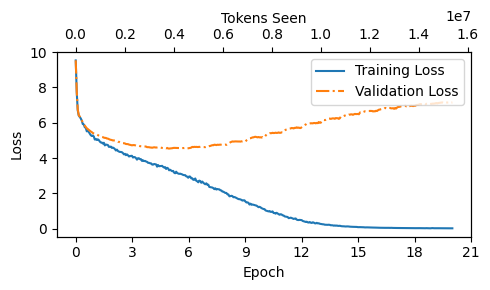

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epoch_seen,
                tokens_seen,
                train_losses,
                val_losses):
  """Plot training and validation loss in xkcd style."""

  fig, ax1 = plt.subplots(figsize=(5, 3))

  # plot training and validation loss against epochs
  ax1.plot(epoch_seen, train_losses, label="Training Loss")
  ax1.plot(epoch_seen, val_losses, linestyle="-.", label="Validation Loss")
  ax1.set_xlabel("Epoch")
  ax1.set_ylabel("Loss")
  ax1.legend(loc="upper right")
  ax1.xaxis.set_major_locator(MaxNLocator(integer=True)) # only show integer labels on x-axis

  # create a second x-axis for token seen
  ax2 = ax1.twiny() # create a second x-axis that shares the same y-axis
  ax2.plot(tokens_seen, train_losses, alpha=0) # invisible plot for aligning ticks
  ax2.set_xlabel("Tokens Seen")

  fig.tight_layout() # asjust layput to make room
  plt.savefig("loss_plot.pdf")
  plt.show()


epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

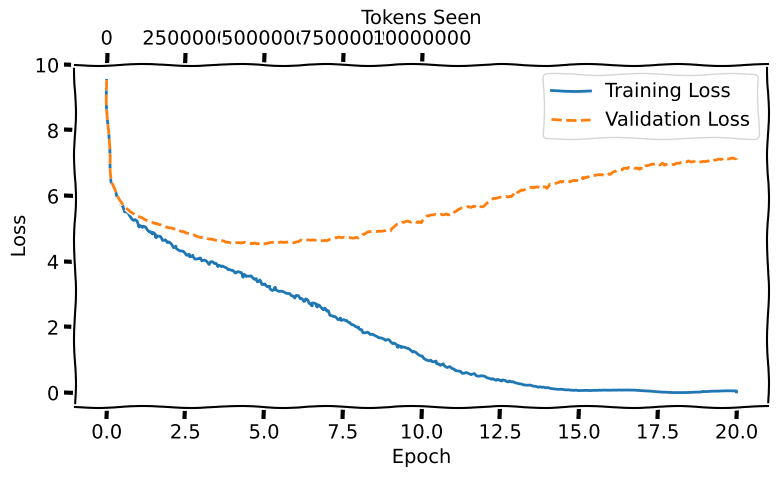

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_losses_xkcd(epochs, tokens, train_losses, val_losses):
    """Plot training and validation loss in XKCD style."""

    # Enable XKCD style
    with plt.xkcd():
        fig, ax1 = plt.subplots(figsize=(8, 5))

        # Plot training and validation loss against epochs
        ax1.plot(epochs, train_losses, label="Training Loss", linewidth=2)
        ax1.plot(epochs, val_losses, linestyle="--", label="Validation Loss", linewidth=2)
        ax1.set_xlabel("Epoch")
        ax1.set_ylabel("Loss")
        ax1.legend(loc="upper right")
        ax1.grid(True, alpha=0.3)

        # Create a second x-axis for tokens seen
        ax2 = ax1.twiny()
        ax2.set_xlim(ax1.get_xlim())
        # Map epoch range to token range
        token_ticks = np.linspace(0, 10000000, 5)
        epoch_ticks = np.linspace(0, 10, 5)
        ax2.set_xticks(epoch_ticks)
        ax2.set_xticklabels([f'{int(t)}' for t in token_ticks])
        ax2.set_xlabel("Tokens Seen")

        plt.tight_layout()
        plt.show()

# Call the function
plot_losses_xkcd(epochs_tensor, tokens_seen, train_losses, val_losses)

## Decoding Strategies To Control Randomness

In [ ]:
model.to("cpu")
model.eval()

bpe_tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(model=model,
                                 input_batch=text_to_token_ids("In the midst of winter, I found",
                                                               bpe_tokenizer),
                                 max_new_tokens=20,
                                 context_size=GPT_CONFIG_124M["context_length"]
                                 )


print("output text: \n", token_ids_to_text(token_ids, bpe_tokenizer))

output text: 
 In the midst of winter, I found any general
exhausted faces of the spectators. I came simply to help him and
only


### Temperature Scaling

In [ ]:
# example setup
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}

inverse_vocab = {v: k for k, v in vocab.items()}

# Suppose input is "every effort moves you", and the LLM
# returns the following logits for the next token:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()

# The next generated token is then as follows:
print(inverse_vocab[next_token_id])

forward


In [ ]:
torch.manual_seed(211)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

forward


In [ ]:
def print_sampled_tokens(probas):
    torch.manual_seed(211) # Manual seed for reproducibility
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample), minlength=len(probas))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

75 x closer
2 x every
0 x effort
568 x forward
3 x inches
2 x moves
0 x pizza
350 x toward
0 x you


In [ ]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

# Temperature values
temperatures = [1, 0.1, 5]  # Original, higher confidence, and lower confidence

# Calculate scaled probabilities
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

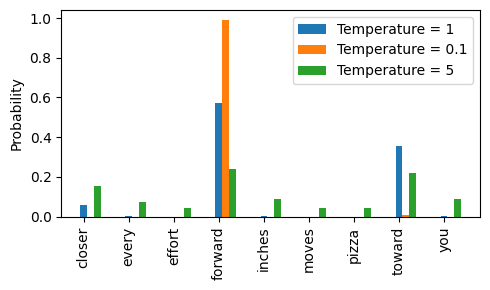

In [ ]:
# Plotting
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

In [ ]:

print_sampled_tokens(scaled_probas[1])

0 x closer
0 x every
0 x effort
987 x forward
0 x inches
0 x moves
0 x pizza
13 x toward
0 x you


In [ ]:
print_sampled_tokens(scaled_probas[2])

158 x closer
76 x every
42 x effort
243 x forward
86 x inches
52 x moves
40 x pizza
228 x toward
75 x you


### Top-k Sampling

In [ ]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)

print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [ ]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float("-inf")),
    other=next_token_logits
)

print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


see https://github.com/rasbt/LLMs-from-scratch/discussions/326

In [ ]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


### Modifying The Text Generation Function

Let's add `temperature sampling` and `top-k` sampling to the `generate_text_simple()` function from `ch04.py`:

In [ ]:
def generate_text(model,
                  input_batch,
                  max_new_tokens,
                  context_size,
                  temperature=0.0,
                  top_k=None,
                  eos_id=None):
  for _ in range(max_new_tokens):
    # crop current context if it exceeds the supported context_size
    crop_input_batch = input_batch[:, -context_size:]

    # predict next token
    with torch.no_grad():
      logits = model(crop_input_batch)

    # consider only logits of the last token
    logits = logits[:, -1, :] # (batch, n_tokens, vocab_size) -> (batch, vocab_size)

    # NEW: filter logits with top_k sampling
    if top_k is not None:
      # keep only top_k values
      top_logits, _ = torch.topk(logits, top_k)
      min_val = top_logits[:, -1] # min value among the top_k values
      # all values other than top_k values will be set to -inf
      logits = torch.where(logits < min_val,
                           torch.tensor(-torch.inf).to(logits.device),
                           logits)

    # NEW: temperature scaling
    if temperature > 0.0:
      logits = logits / temperature

      probas = torch.softmax(logits, dim=-1) # (batch, vocab_size)
      predicted_tokens = torch.multinomial(probas, num_samples=1) # (batch, 1)

    else: # same as before
      #probas = torch.softmax(logits, dim=-1) # (batch, vocab_size)
      predicted_tokens = torch.argmax(logits, dim=-1, keepdim=True) # (batch, 1)

    if predicted_tokens == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

    # update input_batch (append predicted tokens to the sequences)
    input_batch = torch.cat([input_batch, predicted_tokens], dim=1) # [batch, num_tokens+1]

  return input_batch

In [ ]:
# test the function
torch.manual_seed(211)
token_ids = generate_text(model=model,
                          input_batch=text_to_token_ids("In the midst of winter, I found",
                                                        bpe_tokenizer),
                          max_new_tokens=20,
                          context_size=GPT_CONFIG_124M["context_length"],
                          temperature=1.4,
                          top_k=25
                          )

print("output text: \n", token_ids_to_text(token_ids, bpe_tokenizer))

output text: 
 In the midst of winter, I found in the distance across the river, and when he learned that
the proofs he is exchanged something angrily


## Load And Save Model Weights In Pytorch

In [ ]:
# save model state_dict
torch.save(model.state_dict(), "model.pth")

In [ ]:
# load model state_dict
model = GPT2Model(GPT_CONFIG_124M)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("model.pth", map_location=device, weights_only=True))
model.eval()

GPT2Model(
  (token_emb): Embedding(50257, 768)
  (position_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (output_projection): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feed_forward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (layer_norm1): LayerNorm()
      (layer_norm2): LayerNorm()
      (drop_skip): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attention): Mu

We can save and load model together with the optimizers' additional parameters:

In [ ]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    },
    "model_and_optimizer.pth"
)

In [ ]:
checkpoint = torch.load("model_and_optimizer.pth", weights_only=True)

model = GPT2Model(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train()

GPT2Model(
  (token_emb): Embedding(50257, 768)
  (position_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (output_projection): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feed_forward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (layer_norm1): LayerNorm()
      (layer_norm2): LayerNorm()
      (drop_skip): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attention): Mu

## Loading Pretrained Weights From OpenAI

In [ ]:
from importlib.metadata import version

print("TensorFlow version:", version("tensorflow"))
print("tqdm version:", version("tqdm"))

TensorFlow version: 2.18.0
tqdm version: 4.67.1


In [ ]:
import urllib.request

url = (
    "https://raw.githubusercontent.com/rasbt/"
    "LLMs-from-scratch/main/ch05/"
    "01_main-chapter-code/gpt_download.py"
)
filename = url.split("/")[-1]
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x7a4fb40d4d50>)

In [ ]:
from gpt_download import download_and_load_gpt2

settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 153kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 2.83MiB/s]
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 217kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [00:33<00:00, 14.9MiB/s]
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 11.9MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:00<00:00, 1.90MiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 1.58MiB/s]


In [ ]:
print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [ ]:
print(params["wte"])
print("Token embedding weight tensor dimensions:", params["wte"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


In [ ]:
# Define model configurations in a dictionary for compactness
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# Copy the base configuration and update with specific model settings
model_name = "gpt2-small (124M)"  # Example model name
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})

gpt = GPT2Model(NEW_CONFIG)
gpt.eval()

GPT2Model(
  (token_emb): Embedding(50257, 768)
  (position_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (output_projection): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feed_forward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (layer_norm1): LayerNorm()
      (layer_norm2): LayerNorm()
      (drop_skip): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attention): Mult

In [ ]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

### **1. Overall GPT-2 Structure**
GPT-2 follows the Transformer decoder stack, repeated multiple times:

```css
token_emb + pos_emb
→ [LayerNorm + Multi-Head Attention + Residual + LayerNorm + FeedForward + Residual] × N
→ final LayerNorm
→ output linear projection (to vocab size)
```

### **2. OpenAI GPT-2 weight components**
Here’s how weights are named in OpenAI’s checkpoint (and in your params dict):

| Parameter                            | Shape in pretrained weights | Purpose                                  |
| ------------------------------------ | --------------------------- | ---------------------------------------- |
| `'wte'`                              | `[vocab_size, emb_dim]`     | Word token embeddings                    |
| `'wpe'`                              | `[context_length, emb_dim]` | Positional embeddings                    |
| `'blocks[n]["attn"]["c_attn"]["w"]'` | `[emb_dim, 3 × emb_dim]`    | Query, Key, Value weight matrix combined |
| `'blocks[n]["attn"]["c_proj"]["w"]'` | `[emb_dim, emb_dim]`        | Output projection for attention          |
| `'blocks[n]["mlp"]["c_fc"]["w"]'`    | `[emb_dim, 4 × emb_dim]`    | First FFN linear layer                   |
| `'blocks[n]["mlp"]["c_proj"]["w"]'`  | `[4 × emb_dim, emb_dim]`    | Second FFN linear layer                  |
| `'blocks[n]["ln_1"]["g"]'` and `"b"` | `[emb_dim]`                 | LayerNorm 1 (scale & shift)              |
| `'blocks[n]["ln_2"]["g"]'` and `"b"` | `[emb_dim]`                 | LayerNorm 2 (scale & shift)              |
| `'g'`, `'b'`                         | `[emb_dim]`                 | Final LayerNorm parameters               |


### **3. QKV weights Combined:**

In OpenAI's implementation, Q, K, and V are computed from a single linear projection:

```python
c_attn = Linear(emb_dim, 3 * emb_dim)
```
So they store all 3 as a single weight matrix and split it later:

```python
q_w, k_w, v_w = np.split(params["blocks"][b]["attn"]["c_attn"]["w"], 3, axis=-1)
```

The same goes for the biases:

```python
q_b, k_b, v_b = np.split(..., 3, axis=-1)
```

### **4. Weight Transposition**

Weights are stored in OpenAI checkpoints in `[in_dim, out_dim]` format (as NumPy arrays), but PyTorch expects `[out_dim, in_dim]`.

So you must transpose when assigning:

```python
params["blocks"][b]["attn"]["c_attn"]["w"].T
```

### **5. Weight Hierarchy**

Here’s a simplified structure of one transformer block:

```css
GPTModel
├── token_emb        ← wte
├── position_emb     ← wpe
├── trf_blocks (12/24/36/48 blocks)
│   └── [n]
│       ├── att
│       │   ├── W_query.weight ← Q from c_attn
│       │   ├── W_key.weight   ← K from c_attn
│       │   ├── W_value.weight ← V from c_attn
│       │   ├── out_proj.weight ← c_proj
│       └── ff (FeedForward)
│           ├── layers[0].weight ← c_fc
│           ├── layers[2].weight ← c_proj
│       └── norm1/2 ← ln_1 / ln_2
├── final_norm        ← g / b
├── out_head          ← wte (tied to input embedding)

```

### **6. Helpful Tools To Inspect Weights**

```python
# List all top-level keys in params
print(params.keys())

# See what's inside the first transformer block
print(params["blocks"][0].keys())

# Shape of the first layer norm gamma
print(params["blocks"][0]["ln_1"]["g"].shape)
```

In [ ]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.position_emb.weight = assign(gpt.position_emb.weight, params['wpe'])
    gpt.token_emb.weight = assign(gpt.token_emb.weight, params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.transformer_blocks[b].attention.W_query.weight = assign(
            gpt.transformer_blocks[b].attention.W_query.weight, q_w.T)
        gpt.transformer_blocks[b].attention.W_key.weight = assign(
            gpt.transformer_blocks[b].attention.W_key.weight, k_w.T)
        gpt.transformer_blocks[b].attention.W_value.weight = assign(
            gpt.transformer_blocks[b].attention.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.transformer_blocks[b].attention.W_query.bias = assign(
            gpt.transformer_blocks[b].attention.W_query.bias, q_b)
        gpt.transformer_blocks[b].attention.W_key.bias = assign(
            gpt.transformer_blocks[b].attention.W_key.bias, k_b)
        gpt.transformer_blocks[b].attention.W_value.bias = assign(
            gpt.transformer_blocks[b].attention.W_value.bias, v_b)

        gpt.transformer_blocks[b].attention.output_projection.weight = assign(
            gpt.transformer_blocks[b].attention.output_projection.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.transformer_blocks[b].attention.output_projection.bias = assign(
            gpt.transformer_blocks[b].attention.output_projection.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.transformer_blocks[b].feed_forward.layers[0].weight = assign(
            gpt.transformer_blocks[b].feed_forward.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.transformer_blocks[b].feed_forward.layers[0].bias = assign(
            gpt.transformer_blocks[b].feed_forward.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.transformer_blocks[b].feed_forward.layers[2].weight = assign(
            gpt.transformer_blocks[b].feed_forward.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.transformer_blocks[b].feed_forward.layers[2].bias = assign(
            gpt.transformer_blocks[b].feed_forward.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.transformer_blocks[b].layer_norm1.scale = assign(
            gpt.transformer_blocks[b].layer_norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.transformer_blocks[b].layer_norm1.shift = assign(
            gpt.transformer_blocks[b].layer_norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.transformer_blocks[b].layer_norm2.scale = assign(
            gpt.transformer_blocks[b].layer_norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.transformer_blocks[b].layer_norm2.shift = assign(
            gpt.transformer_blocks[b].layer_norm2.shift,
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])


load_weights_into_gpt(gpt, params)
gpt.to(device)

GPT2Model(
  (token_emb): Embedding(50257, 768)
  (position_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (output_projection): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feed_forward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (layer_norm1): LayerNorm()
      (layer_norm2): LayerNorm()
      (drop_skip): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attention): Mult

Let's generate text with OpenAI's pretrained weights:

In [ ]:
torch.manual_seed(123)

token_ids = generate_text(
    model=gpt,
    input_batch=text_to_token_ids("In the midst of winter, I found", bpe_tokenizer).to(device),
    max_new_tokens=100,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

print("Output text:\n", token_ids_to_text(token_ids, bpe_tokenizer))

Output text:
 In the midst of winter, I found the weather in the neighborhood very very rainy (and that means we had only a week's supply of winter tires before getting here anyway) so by winter I was getting sick, and I was worried that you might want to consider visiting me for only one day (which turned out not to work because of the dry condition there) so I called our vet because she found her car had been found frozen by snow, and that was hard...until about 6 p. of every month the same year."




In [ ]:
notebook_end_time = time.time()
runtime_in_seconds = notebook_end_time - notebook_start_time

# format as minutes and seconds
minutes, seconds = divmod(runtime_in_seconds, 60)
print(f"Notebook runtime: {int(minutes)} min {seconds:.2f} sec")

Notebook runtime: 30 min 6.34 sec
